Задание
 - Выполнить преобразования, аналогичные пункту 1.6, используя частотную область (лень)
 - Считать изображение МРТ
 - Добавить на изображение гауссов и импульсный шум
 - Определить наиболее эффективный ФНЧ в частотной области, используя в качестве критерия показатель PSNR

In [57]:
import cv2 as cv
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math
from math import sqrt, exp
from skimage import io
import scipy.ndimage as ndi

(975, 610, 3)
(975, 610)


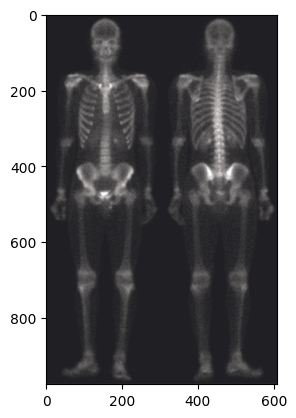

In [4]:
img = cv.imread('xray.png')
plt.imshow(img)
print(img.shape)
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
print(img.shape)

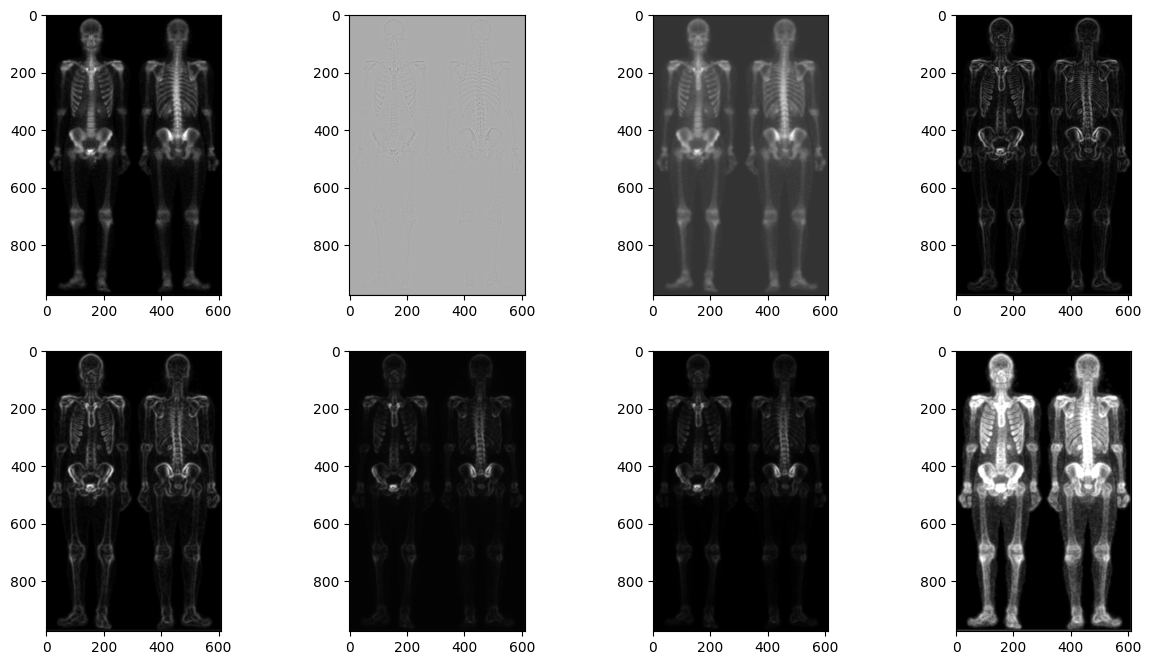

In [60]:
image_xray = io.imread("xray.png", as_gray=True)

image_xray_lapl = cv.Laplacian(image_xray, cv.CV_64F)
image_xray_sum = image_xray + image_xray_lapl

sobelx = cv.Sobel(image_xray_sum, cv.CV_64F, 1, 0, ksize=5)
sobely = cv.Sobel(image_xray_sum, cv.CV_64F, 0, 1, ksize=5)
image_xray_sobel = np.sqrt(sobelx**2 + sobely**2)

mean_filter = np.ones((5,5))
mean_coef = 1/25
image_xray_mean = ndi.convolve(image_xray_sobel, mean_filter)*mean_coef

image_xray_mult = image_xray_sum * image_xray_mean

image_xray_sum2 = image_xray + image_xray_mult

mid = 0.9
mean = np.mean(image_xray_sum2)
gamma = math.log(mid)/math.log(mean)

# do gamma correction
img_gamma1 = np.power(image_xray_sum2, gamma).clip(0,1.1)

l = [image_xray, image_xray_lapl, image_xray_sum, image_xray_sobel, image_xray_mean, image_xray_mult, image_xray_sum2, img_gamma1]
fig, ax = plt.subplots(2, 4, figsize=(15, 8))
ax = ax.ravel()
for i in range(len(ax)):
  ax[i].imshow(l[i], cmap='gray')
fig.show()

Text(0.5, 1.0, 'Centered')

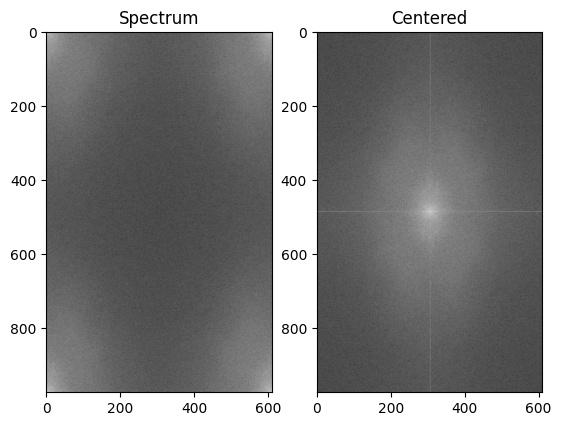

In [11]:
img_fft = np.fft.fft2(img)
centered = np.fft.fftshift(img_fft)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(np.log10(1 + abs(img_fft)), cmap='gray')
ax[0].set_title('Spectrum')
ax[1].imshow(np.log10(1 + abs(centered)), cmap='gray')
ax[1].set_title('Centered')

Text(0.5, 1.0, 'Centered')

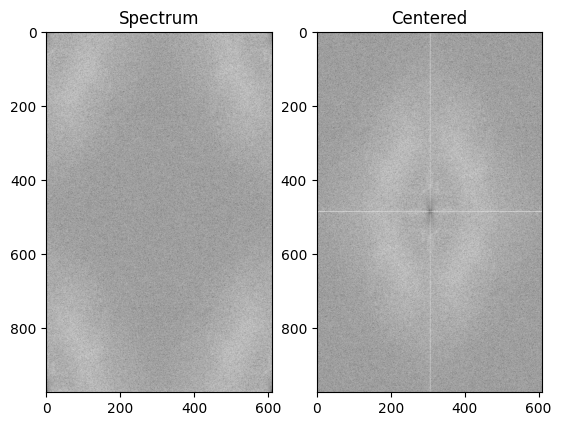

In [12]:
laplacian = cv.Laplacian(img, cv.CV_64F)
lap_fft = np.fft.fft2(laplacian)
lap_centered = np.fft.fftshift(lap_fft)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(np.log10(1 + abs(lap_fft)), cmap='gray')
ax[0].set_title('Spectrum')
ax[1].imshow(np.log10(1 + abs(lap_centered)), cmap='gray')
ax[1].set_title('Centered')

Text(0.5, 1.0, 'Centered')

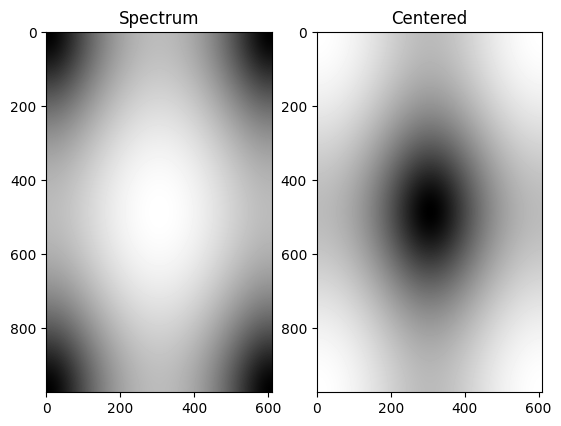

In [32]:
filter = np.array([[0, 1, 0],
                   [1, -4, 1],
                   [0, 1, 0]])

fil_fft = np.fft.fft2(filter, s=img.shape)
fil_centered = np.fft.fftshift(fil_fft)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(np.log10(1 + abs(fil_fft)), cmap='gray')
ax[0].set_title('Spectrum')
ax[1].imshow(np.log10(1 + abs(fil_centered)), cmap='gray')
ax[1].set_title('Centered')

Text(0.5, 1.0, 'Centered')

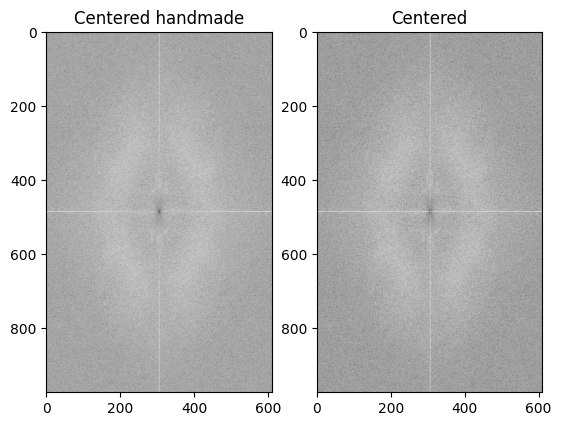

In [95]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(np.log10(1 + abs(fil_centered*centered)), cmap='gray')
ax[0].set_title('Centered handmade')
ax[1].imshow(np.log10(1 + abs(lap_centered)), cmap='gray')
ax[1].set_title('Centered')

Не понятно как востановить двумерное БПФ от свертки(

In [52]:
np.mean(abs(fil_centered*centered) / abs(lap_centered))

0.9997253543247401

Ну хотя почти тоже самое

In [66]:
# Сгенерируем гауссов шум
mu = 0
sigma = 0.1
noise_g = np.random.normal(mu, sigma, (img.shape[0], img.shape[1]))

# Добавим гауссов шум на исходное изображение
image_noised = img + noise_g

# Сгенерируем шум по типу "Соль и перец"
size_salt = 35000
I_s_x = np.random.randint(0, img.shape[0], size_salt)
I_s_y = np.random.randint(0, img.shape[1], size_salt)

# Перец
size_pepper = 30000
I_p_x = np.random.randint(0, img.shape[0], size_pepper)
I_p_y = np.random.randint(0, img.shape[1], size_pepper)

# Добавим соли
for i in range(0, I_s_y.shape[0]):
    image_noised[I_s_x[i],I_s_y[i]] = 1.0

# Добавим перца
for i in range(0, I_p_y.shape[0]):
    image_noised[I_p_x[i],I_p_y[i]] = 0.0

(-0.5, 609.5, 974.5, -0.5)

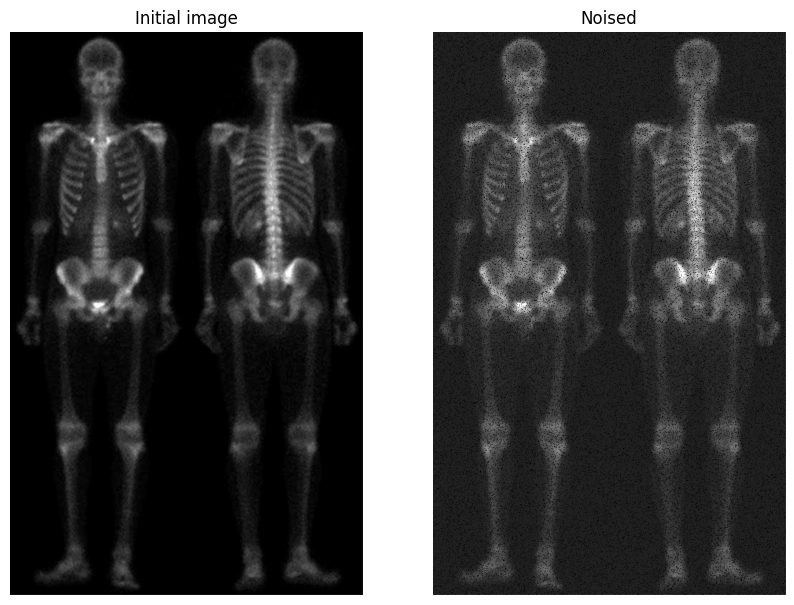

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(10, 9))
axs[0].imshow(img, cmap="gray")
axs[0].title.set_text(f'Initial image')
axs[0].axis("off")

axs[1].imshow(image_noised, cmap="gray")
axs[1].title.set_text(f'Noised')
axs[1].axis("off")

In [100]:
def getPSNR(I1, I2):
    """
    Higher - better
    """

    s1 = cv.absdiff(I1.astype('float64'), I2.astype('float64')) #|I1 - I2|
    s1 = np.float32(s1)     # cannot make a square on 8 bits
    s1 = s1 * s1            # |I1 - I2|^2
    sse = s1.sum()          # sum elements per channel
    if sse <= 1e-10:        # sum channels
        print("The same image")            # for small values return zero
        return 0
    else:
        shape = I1.shape
        mse = 1.0 * sse / shape[0] / shape[1]
        psnr = 10.0 * np.log10((255 * 255) / mse)
        print(f"Signal to noise ratio (higher - better): {psnr: .2f}")
        return psnr

In [69]:
def distance(point1,point2):
    return sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)

def idealFilterLP(D0,imgShape):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            if distance((y,x),center) < D0:
                base[y,x] = 1
    return base

def butterworthLP(D0,imgShape,n):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            base[y,x] = 1/(1+(distance((y,x),center)/D0)**(2*n))
    return base

def gaussianLP(D0,imgShape):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            base[y,x] = exp(((-distance((y,x),center)**2)/(2*(D0**2))))
    return base

In [75]:
image_noised.dtype

dtype('float64')

Noised
Signal to noise ratio (higher - better):  22.75
Ideal
Signal to noise ratio (higher - better):  29.80
Butterworth
Signal to noise ratio (higher - better):  29.95
Gauss
Signal to noise ratio (higher - better):  29.88


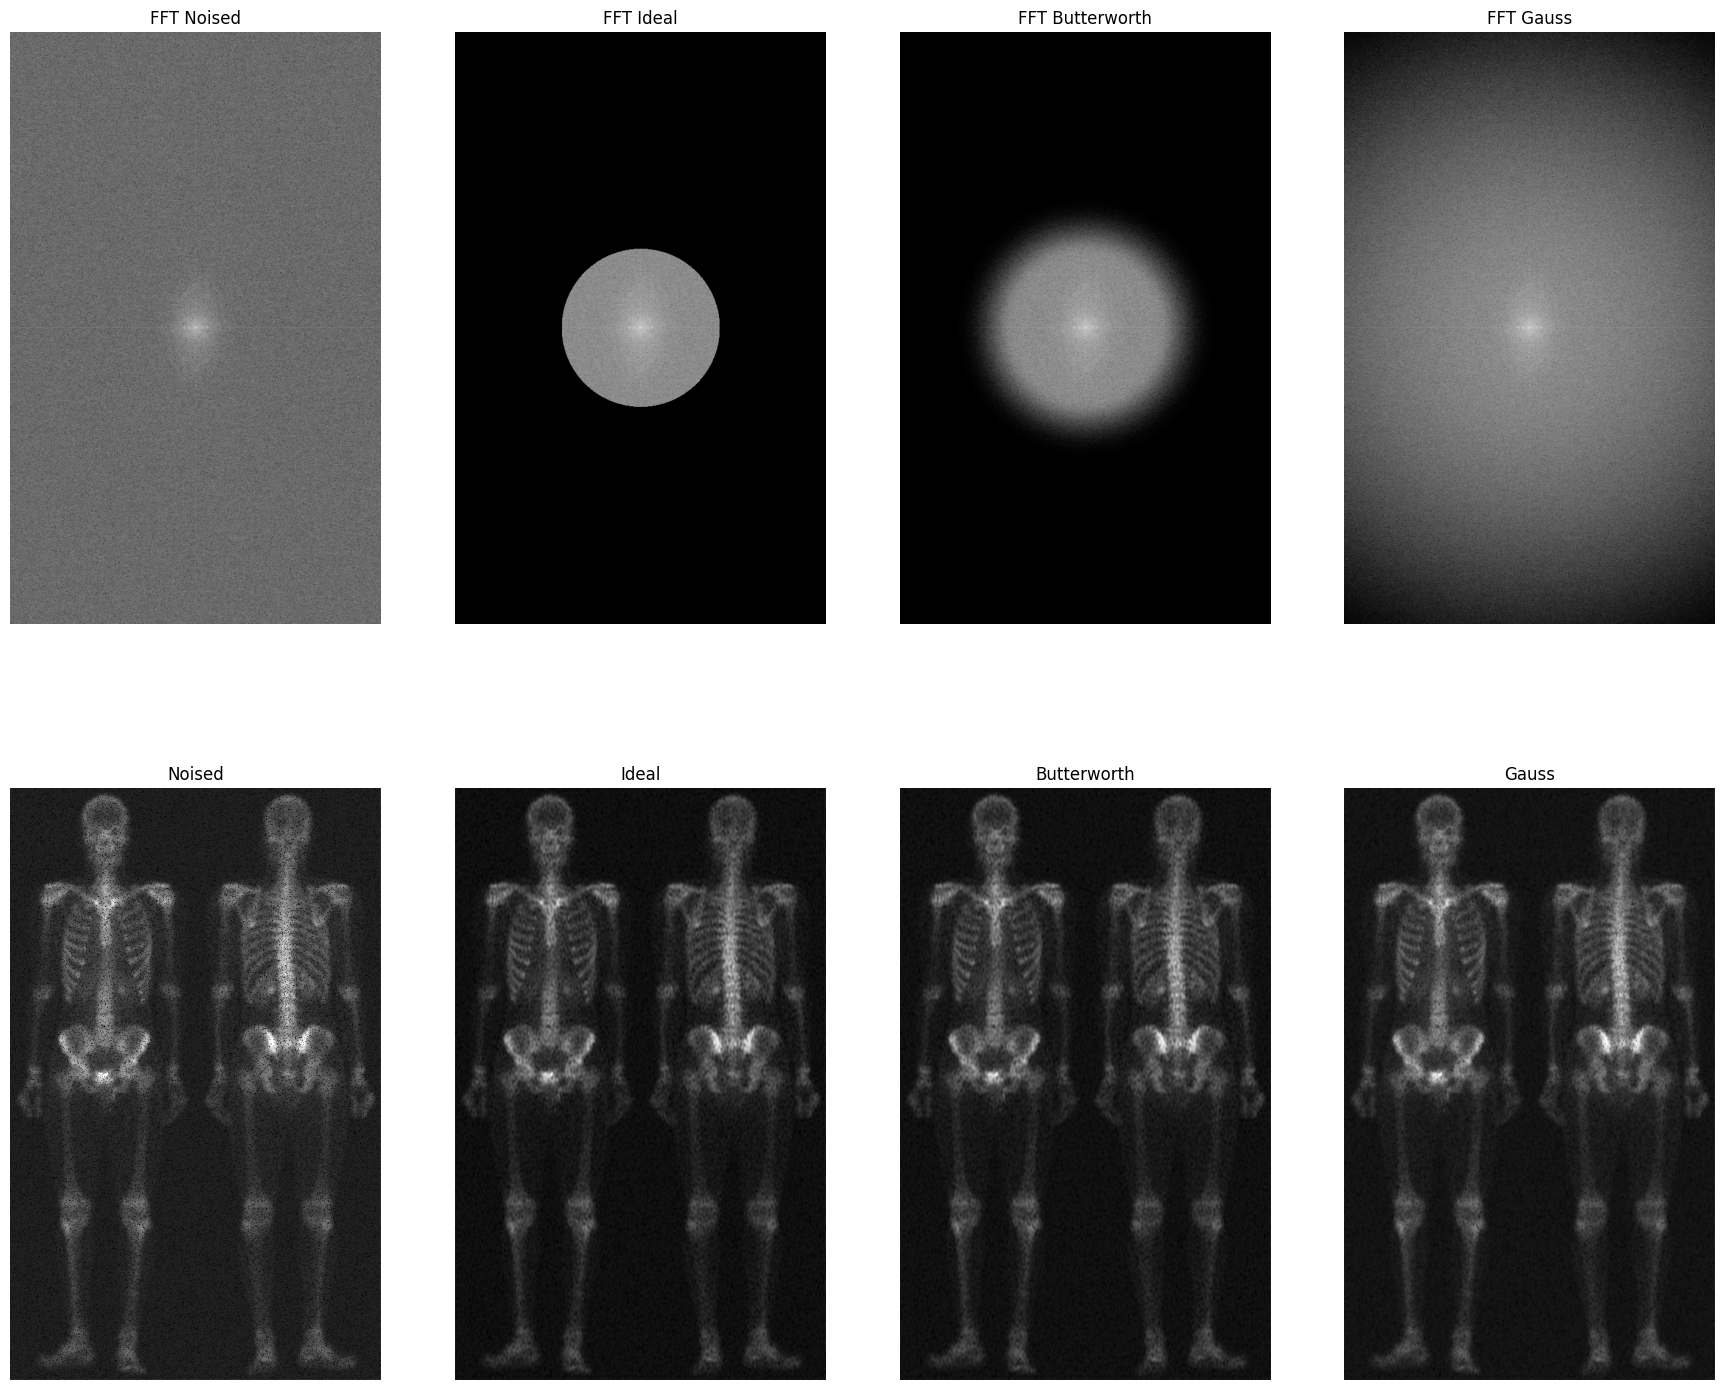

In [102]:
noise_fft = np.fft.fft2(image_noised)
noise_center = np.fft.fftshift(noise_fft)

fig, ax = plt.subplots(2, 4, figsize=(22, 18))
ax[0, 0].imshow(np.log10(1+abs(noise_center)), cmap='gray')
ax[0, 0].axis('off')
ax[0, 0].set_title('FFT Noised')
ax[1, 0].imshow(image_noised, cmap='gray')
ax[1, 0].axis('off')
ax[1, 0].set_title('Noised')
print("Noised")
_ = getPSNR(img, image_noised)


LowPassCenter = noise_center * idealFilterLP(130, img.shape)
LowPass = np.fft.ifftshift(LowPassCenter)
inverse_LowPass = np.fft.ifft2(LowPass)
ax[0, 1].imshow(np.log10(1+abs(LowPassCenter)), cmap='gray')
ax[0, 1].axis('off')
ax[0, 1].set_title('FFT Ideal')
ax[1, 1].imshow(np.abs(inverse_LowPass), cmap='gray')
ax[1, 1].axis('off')
ax[1, 1].set_title('Ideal')
print("Ideal")
_ = getPSNR(img, np.abs(inverse_LowPass))

LowPassCenter_but = noise_center * butterworthLP(130, img.shape, 12)
LowPass_but = np.fft.ifftshift(LowPassCenter_but)
inverse_LowPass_but = np.fft.ifft2(LowPass_but)
ax[0, 2].imshow(np.log10(1+abs(LowPassCenter_but)), cmap='gray')
ax[0, 2].axis('off')
ax[0, 2].set_title('FFT Butterworth')
ax[1, 2].imshow(np.abs(inverse_LowPass_but), cmap='gray')
ax[1, 2].axis('off')
ax[1, 2].set_title('Butterworth')
print("Butterworth")
_ = getPSNR(img, np.abs(inverse_LowPass_but))

LowPassCenter_gs = noise_center * gaussianLP(130, img.shape)
LowPass_gs = np.fft.ifftshift(LowPassCenter_gs)
inverse_LowPass_gs = np.fft.ifft2(LowPass_gs)
ax[0, 3].imshow(np.log10(1+abs(LowPassCenter_gs)), cmap='gray')
ax[0, 3].axis('off')
ax[0, 3].set_title('FFT Gauss')
ax[1, 3].imshow(np.abs(inverse_LowPass_gs), cmap='gray')
ax[1, 3].axis('off')
ax[1, 3].set_title('Gauss')
print("Gauss")
_ = getPSNR(img, np.abs(inverse_LowPass_gs))